# 📊 SPC ReportBot

Automated Statistical Process Control (SPC) analysis pipeline that:
1. **Data Availability Check**: Verifies data freshness before processing
2. Pulls metrics from BigQuery (daily/weekly/monthly grain)
3. Runs XmR detection rules for anomaly detection
4. Generates AI-powered commentary via Gemini
5. Publishes to Slack

## ⚙️ Data Availability Mechanism

The notebook includes automatic data freshness checks:
- **All grains** (daily/weekly/monthly): Expects data within 1 day

If data is stale or missing:
- Sends a Slack alert to notify the team
- Optionally stops report generation (configurable)
- Logs details about data lag for debugging

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import os
import json
import logging
import requests
import io
import re
from datetime import datetime
from google.cloud import bigquery
from dotenv import load_dotenv
from statsmodels.tsa.seasonal import STL

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# ── Project parameters ───────────────────────────────────────────────────────
bq_project = 'syb-production-analytics'

# ── Semantic / SPC Configuration ─────────────────────────────────────────────
@dataclass
class SPCConfig:
    """Configuration for SPC Analysis and Reporting.

    Only three columns need to be specified:
      1. metric_column – the "x" variable (one chart per unique value)
      2. date_column   – the time-series date column
      3. value_column  – the numeric measure column

    Every other column in the dataframe is automatically treated as a
    drill-down dimension.
    """

    # ── Semantic layer (only 3 things to specify) ─────────────────────────
    grain: str = 'weekly'                          # 'daily' | 'weekly' | 'monthly'
    date_column: str = 'period'                   # the date / time column
    value_column: str = 'value'                   # the numeric measure column
    metric_column: str = 'measure'                # groups data into one chart per unique value

    # ── SPC parameters ───────────────────────────────────────────────────
    rules_active: List[int] = field(default_factory=lambda: [1, 2, 3])
    min_data_points: int = 10
    spc_window: int = 52          # number of data points used to calculate control limits
    report_window: int = 1        # number of most-recent data points the report covers (1 = last data point)
    deseasonalize: bool = True    # run STL decomposition for seasonal context

    # ── Report settings ──────────────────────────────────────────────────
    team_name: str = "Soundtrack Analytics"
    notion_doc_url: str = "https://www.notion.so/soundtrackapp/Statistical-Process-Control-f1240ea250db424391675a2477ce84a4"

    # ── Visual styling ───────────────────────────────────────────────────
    colors: Dict[str, str] = field(default_factory=lambda: {
        'primary': '#000000',
        'mean_line': '#9E6EFF',
        'control_limits': '#F23440',
        'zone_lines': '#D6C2FF',
        'background': '#F5F4F5',
        'chart_bg': '#FFFFFF',
    })

    rule_colors: Dict[str, str] = field(default_factory=lambda: {
        'rule_1': '#F23440',
        'rule_2': '#FF9800',
        'rule_3': '#1976D2',
    })

    # ── Grain-aware labels ───────────────────────────────────────────────
    @property
    def grain_label(self) -> str:
        """Human-readable grain label: 'day', 'week', or 'month'."""
        return {'daily': 'day', 'weekly': 'week', 'monthly': 'month'}[self.grain]

    @property
    def grain_label_plural(self) -> str:
        return {'daily': 'days', 'weekly': 'weeks', 'monthly': 'months'}[self.grain]

    @property
    def grain_adjective(self) -> str:
        """'Daily', 'Weekly', or 'Monthly'."""
        return self.grain.capitalize()

    @property
    def report_title(self) -> str:
        return f"{self.grain_adjective} SPC Report"

    @property
    def report_period_label(self) -> str:
        """Describes the report window, e.g. 'last day', 'last 3 weeks'."""
        if self.report_window == 1:
            return f"last {self.grain_label}"
        return f"last {self.report_window} {self.grain_label_plural}"

    @property
    def seasonality_period(self) -> Optional[int]:
        """Default STL period: 7 (day-of-week) for daily, 52/12 for weekly/monthly."""
        return {'daily': 7, 'weekly': 52, 'monthly': 12}.get(self.grain)

    @property
    def stl_lookback(self) -> int:
        """Max data points fed to STL: 3 years in grain-appropriate units."""
        return {'daily': 365 * 3, 'weekly': 53 * 3, 'monthly': 12 * 3}[self.grain]

    def get_metric_label(self, metric_name: str) -> str:
        """Auto-generate a friendly label from the raw metric name.

        Strips parenthesized content, replaces underscores/double-underscores
        with spaces, and title-cases the result.
        """
        label = re.sub(r'\s*\([^)]*\)', '', metric_name)   # strip (…)
        label = label.replace('__', ' ').replace('_', ' ')  # separators → spaces
        label = re.sub(r'\s+', ' ', label).strip()          # collapse whitespace
        return label.title()


SPC_DETECTION_RULES = {
    'rule_1': {
        'name': 'Rule 1: Process Limit',
        'short': 'R1: Outside limits',
        'description': 'A single point falls outside the 3σ process limits',
        'business_explanation': 'an extreme value outside normal operating range (beyond process limits)',
        'severity': 'critical',
        'action': 'Investigate immediately — likely a special cause event',
    },
    'rule_2': {
        'name': 'Rule 2: Quartile Limit',
        'short': 'R2: 3/4 past midpoint',
        'description': '3 out of 4 consecutive points fall closer to a limit than to the centre line (beyond ±1.5σ on the same side)',
        'business_explanation': 'unusual clustering near a process limit (3 of 4 points past the midpoint)',
        'severity': 'high',
        'action': 'Monitor closely — early warning of potential shift',
    },
    'rule_3': {
        'name': 'Rule 3: Runs of Eight',
        'short': 'R3: 8 same side',
        'description': '8 consecutive points fall on the same side of the centre line',
        'business_explanation': 'a sustained shift in the process level (8 consecutive points on same side)',
        'severity': 'high',
        'action': 'Process mean has likely shifted — investigate root cause',
    },
    'mr_violation': {
        'name': 'MR Violation: Beyond UCL',
        'short': 'MR > UCL',
        'description': 'Moving Range exceeds Upper Control Limit',
        'business_explanation': 'unusual volatility between consecutive data points',
        'severity': 'high',
        'action': 'Investigate sudden change — check for data quality or real event',
    },
}

config = SPCConfig()

print("✅ Imports & config loaded")
print(f"   Grain: {config.grain} → report = {config.report_title}")
print(f"   Columns: metric={config.metric_column}, date={config.date_column}, value={config.value_column}")

print(f"   SPC window: {config.spc_window} data points")
print(f"   Report covers: {config.report_period_label}")
print(f"   Active rules: {config.rules_active}")
print(f"   Seasonality: {'STL enabled' if config.deseasonalize else 'off'} (period={config.seasonality_period})")
print(f"   Dimensions: auto-detected from data (everything except the 3 columns above)")

✅ Imports & config loaded
   Grain: weekly → report = Weekly SPC Report
   Columns: metric=measure, date=period, value=value
   SPC window: 52 data points
   Report covers: last week
   Active rules: [1, 2, 3]
   Seasonality: STL enabled (period=52)
   Dimensions: auto-detected from data (everything except the 3 columns above)


In [3]:
# ── Load environment variables early for data checks ─────────────────────────
load_dotenv(override=True)
SLACK_BOT_TOKEN = os.environ.get('SLACK_BOT_TOKEN')

SLACK_CHANNEL = os.environ.get('SLACK_CHANNEL', '#spc-reports')
SLACK_WEBHOOK_URL = os.environ.get('SLACK_WEBHOOK_URL')

## 🔍 Data Availability Check

This section verifies that fresh data is available before running the full report.

In [4]:
def check_data_availability(client: bigquery.Client, grain: str = 'weekly',
                             _test_max_date: str = None) -> dict:
    """Check whether the source table has data covering the expected reporting period.

    For **weekly** grain the expected latest date is yesterday (T-1).  The
    check queries the actual MAX(partition_date) in BigQuery and compares it.

    Parameters
    ----------
    _test_max_date : str, optional
        Override for testing — pretend the latest data is this date
        (format YYYY-MM-DD) instead of querying BigQuery.

    Returns
    -------
    dict with keys:
        is_available, status, message, max_date, expected_date, days_lag
    """
    from datetime import timedelta

    if _test_max_date:
        max_date = pd.to_datetime(_test_max_date)
    else:
        query = """
        SELECT MAX(partition_date) AS max_partition_date
        FROM `syb-production-analytics.KeyMetrics.KeyMetricsDaily`
        """
        result = client.query(query).to_dataframe()

        if result.empty or pd.isna(result.loc[0, 'max_partition_date']):
            return dict(is_available=False, status='missing',
                        message='❌ No data found in source table at all',
                        max_date=None, expected_date=None, days_lag=None)

        max_date = pd.to_datetime(result.loc[0, 'max_partition_date'])

    today = pd.Timestamp.now().normalize()
    expected_date = today - timedelta(days=1)          # T-1 for all grains
    days_lag = (today - max_date).days

    if days_lag <= 1:
        return dict(is_available=True, status='ok',
                    message=f"✅ Data is fresh (latest: {max_date.strftime('%Y-%m-%d')}, {days_lag}d lag)",
                    max_date=max_date.strftime('%Y-%m-%d'),
                    expected_date=expected_date.strftime('%Y-%m-%d'),
                    days_lag=days_lag)
    else:
        return dict(is_available=False, status='missing',
                    message=f"❌ Data is stale (latest: {max_date.strftime('%Y-%m-%d')}, {days_lag}d lag — expected {expected_date.strftime('%Y-%m-%d')})",
                    max_date=max_date.strftime('%Y-%m-%d'),
                    expected_date=expected_date.strftime('%Y-%m-%d'),
                    days_lag=days_lag)


def send_slack_data_alert(bot_token: str, channel: str, availability_info: dict, grain: str = 'weekly') -> bool:
    """Post a data-unavailability notice to Slack via the Bot Token API.

    Uses the same chat.postMessage approach as the rest of the notebook
    so it works with the existing SLACK_BOT_TOKEN / SLACK_CHANNEL config.
    """
    status  = availability_info['status']
    max_date = availability_info['max_date']
    days_lag = availability_info['days_lag']
    expected = availability_info['expected_date']

    text = (
        f"🔴 *SPC ReportBot — Data Unavailable*\n\n"
        f"The {grain} SPC report could not be generated because the "
        f"underlying data is not up to date.\n\n"
        f"• *Latest available date:* {max_date}\n"
        f"• *Expected date:* {expected}\n"
        f"• *Lag:* {days_lag} day(s)\n\n"
        f"We're looking into it and will publish the report as soon as "
        f"fresh data is available. 🔧"
    )

    try:
        resp = requests.post(
            "https://slack.com/api/chat.postMessage",
            headers={"Authorization": f"Bearer {bot_token}"},
            json={"channel": channel, "text": text},
            timeout=10,
        )
        ok = resp.json().get("ok", False)
        if ok:
            print(f"✅ Data-unavailability alert posted to {channel}")
        else:
            print(f"❌ Slack API error: {resp.json().get('error')}")
        return ok
    except Exception as e:
        print(f"❌ Failed to send Slack alert: {e}")
        return False

### Configuration

To enable automatic data checks:
1. Set `SLACK_WEBHOOK_URL` in your `.env` file
2. Adjust `REPORT_GRAIN` in the data ingestion cell to match your report frequency
3. Optionally uncomment `raise SystemExit(...)` to halt execution when data is unavailable

**Example `.env` entry:**
```
SLACK_WEBHOOK_URL=https://hooks.slack.com/services/YOUR/WEBHOOK/URL
```

In [5]:
# ── Quick Test: Run data availability check ─────────────────────────────────
# Uncomment to test the data check independently:

# test_client = bigquery.Client(bq_project)
# test_result = check_data_availability(test_client, grain='weekly')
# print(f"\nTest Result:")
# print(f"  Status: {test_result['status']}")
# print(f"  Available: {test_result['is_available']}")
# print(f"  Max Date: {test_result['max_date']}")
# print(f"  Days Lag: {test_result['days_lag']}")
#
# # Test Slack alert (won't actually send without valid webhook)
# if SLACK_WEBHOOK_URL:
#     send_slack_data_alert(SLACK_WEBHOOK_URL, test_result, grain='weekly')

## 1. Data Ingestion

In [6]:
# ── Initialize BigQuery client ───────────────────────────────────────────────
client = bigquery.Client(bq_project)

# ── Perform data availability check ──────────────────────────────────────────
# Adjust grain to match your data aggregation level: 'daily', 'weekly', or 'monthly'
REPORT_GRAIN = 'weekly'  # Change this to match your report frequency

# Set to True to skip the data availability check (useful when testing with older dates)
SKIP_DATA_CHECK = False  # ← set to False for production

# Set to a date string (e.g. '2025-12-28') to simulate stale data, or None for live check
TEST_MAX_DATE = None  # ← set to None for production

if SKIP_DATA_CHECK:
    print("⏭️  Data availability check skipped (SKIP_DATA_CHECK = True)")
else:
    print(f"🔍 Checking data availability for {REPORT_GRAIN} grain...")
    availability = check_data_availability(client, grain=REPORT_GRAIN, _test_max_date=TEST_MAX_DATE)
    print(availability['message'])

    # If data is not available, send alert and skip report generation
    if not availability['is_available']:
        print(f"\n⚠️  Data availability check failed. Sending Slack notification...")
        
        if SLACK_BOT_TOKEN:
            send_slack_data_alert(SLACK_BOT_TOKEN, SLACK_CHANNEL, availability, grain=REPORT_GRAIN)
        else:
            print(f"❌ SLACK_BOT_TOKEN not configured — cannot send alert.")
        
        print(f"\n💡 Report generation skipped. Please check data pipeline and retry.")
        print(f"   Latest available data: {availability['max_date']}")
        print(f"   Expected data by: {availability['expected_date']}")
        print(f"   Current lag: {availability['days_lag']} days")
        
        # Stop execution - data not available
        raise SystemExit("⛔ Data not available — stopping execution")
    else:
        print(f"✅ Data availability check passed. Proceeding with report generation...")
        print(f"   Latest data: {availability['max_date']} (lag: {availability['days_lag']} days)\n")

# ── Fetch context table (metric definitions) ────────────────────────────────
context_query = """
SELECT *
FROM `syb-production-analytics.temp.reportbot_context_view`
"""
df_context = client.query(context_query).to_dataframe()
print(f"✅ Fetched {len(df_context)} metric definitions from reportbot_context_view")

# ── Fetch raw data from BigQuery ─────────────────────────────────────────────
query = f"""
WITH max_available_partition_date AS (
  SELECT MAX(partition_date) AS partition_date
  FROM `syb-production-analytics.KeyMetrics.KeyMetricsDaily`
)

SELECT
  country_region,
  marketing_parent_channel,
  is_internal,
  funnel_name,
  top_of_funnel_step_name,
  bottom_of_funnel_step_name,
  period,
  SUM(nr_users) AS nr_users,
  SUM(nr_users_converted) AS nr_users_converted
FROM `syb-production-analytics.StatisticalProcessControl.Growth` g
WHERE period < DATE_TRUNC(
      (SELECT partition_date FROM max_available_partition_date),
      WEEK(MONDAY)
    )
  AND periodic_interval = 'week'
GROUP BY ALL
"""

df_raw = client.query(query).to_dataframe()
print(f"✅ Fetched {len(df_raw)} rows from Growth table")

# ── Build metrics from context definitions ───────────────────────────────────
# Each row in df_context defines a metric:
#   - filters.is_internal + filters.funnel_name → filter the raw data
#   - top_of_funnel_step_name → the step whose nr_users is the denominator / absolute value
#   - bottom_of_funnel_step_name → if set, nr_users_converted is the numerator (conversion)
#   - If bottom_of_funnel_step_name is NULL → absolute metric (nr_users from top step)
#
# We carry nr_users and nr_users_converted through so the SPC engine can
# re-aggregate correctly (sum counts first, then divide for ratios).

metric_frames = []
dim_cols_raw = ['country_region', 'marketing_parent_channel']

for _, ctx_row in df_context.iterrows():
    metric_name = ctx_row['metric']
    is_internal = ctx_row['filters']['is_internal']
    funnel_name = ctx_row['filters']['funnel_name']
    top_step = ctx_row['top_of_funnel_step_name']
    bottom_step = ctx_row['bottom_of_funnel_step_name']

    # Convert bool to lowercase string to match BigQuery STRING representation
    is_internal_str = str(is_internal).lower()  # True → 'true', False → 'false'

    # Filter raw data to match context row
    mask = (
        (df_raw['is_internal'] == is_internal_str) &
        (df_raw['funnel_name'] == funnel_name) &
        (df_raw['top_of_funnel_step_name'] == top_step)
    )
    if pd.notna(bottom_step):
        mask &= (df_raw['bottom_of_funnel_step_name'] == bottom_step)
    else:
        # Absolute metrics: top step = bottom step (self-referencing row in the funnel table)
        mask &= (df_raw['bottom_of_funnel_step_name'] == top_step)

    subset = df_raw.loc[mask].copy()

    if subset.empty:
        print(f"   ⚠️  No data matched for metric: {metric_name}")
        continue

    # Aggregate per dimension combo × period
    agg = subset.groupby(dim_cols_raw + ['period'], as_index=False).agg(
        nr_users=('nr_users', 'sum'),
        nr_users_converted=('nr_users_converted', 'sum'),
    )

    # Determine metric type and compute value
    is_conversion = pd.notna(bottom_step)
    if is_conversion:
        # Conversion metric: bottom / top
        agg['value'] = (agg['nr_users_converted'] / agg['nr_users']).replace([np.inf, -np.inf], np.nan)
    else:
        # Absolute metric: just the top-of-funnel count
        agg['value'] = agg['nr_users']

    agg['measure'] = metric_name
    agg['metric_type'] = 'conversion' if is_conversion else 'absolute'
    metric_frames.append(agg[dim_cols_raw + ['period', 'value', 'measure', 'metric_type', 'nr_users', 'nr_users_converted']])

df_metrics = pd.concat(metric_frames, ignore_index=True)
print(f"✅ Built {df_metrics['measure'].nunique()} metrics, {len(df_metrics)} total rows")
print(f"   Types: {df_metrics.groupby('metric_type')['measure'].nunique().to_dict()}")

# ── Data scaffolding: ensure every (dimension × date) combo exists per metric ─
# Without this, missing rows would silently deflate aggregates.
date_col = config.date_column
val_col = config.value_column
metric_col = config.metric_column
reserved = {metric_col, date_col, val_col}
dim_cols = [c for c in df_metrics.columns if c not in reserved and c not in ('metric_type', 'nr_users', 'nr_users_converted')]

scaffolded = []
for metric_name, grp in df_metrics.groupby(metric_col):
    # Build full Cartesian product: all dates × all dim combos
    all_dates = grp[date_col].unique()
    if dim_cols:
        dim_combos = grp[dim_cols].drop_duplicates()
        scaffold = dim_combos.assign(_key=1).merge(
            pd.DataFrame({date_col: all_dates, '_key': 1}), on='_key'
        ).drop(columns='_key')
    else:
        scaffold = pd.DataFrame({date_col: all_dates})
    scaffold[metric_col] = metric_name
    merged = scaffold.merge(grp, on=[metric_col, date_col] + dim_cols, how='left')
    merged[val_col] = merged[val_col].fillna(0)
    merged['nr_users'] = merged['nr_users'].fillna(0)
    merged['nr_users_converted'] = merged['nr_users_converted'].fillna(0)
    # Forward-fill metric_type (constant per metric)
    merged['metric_type'] = merged['metric_type'].ffill().bfill()
    scaffolded.append(merged)

df = pd.concat(scaffolded, ignore_index=True)
n_added = len(df) - len(df_metrics)
print(f"   Scaffolded: {len(df)} rows ({n_added} zero-filled rows added)")

🔍 Checking data availability for weekly grain...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✅ Data is fresh (latest: 2026-02-15, 1d lag)
✅ Data availability check passed. Proceeding with report generation...
   Latest data: 2026-02-15 (lag: 1 days)

✅ Fetched 9 metric definitions from reportbot_context_view
✅ Fetched 333838 rows from Growth table
   ⚠️  No data matched for metric: Signup Completed Absolutes
   ⚠️  No data matched for metric: Storefront to Signup Conversion
   ⚠️  No data matched for metric: Storefront Page Views Absolutes
✅ Built 6 metrics, 13755 total rows
   Types: {'absolute': 3, 'conversion': 3}
   Scaffolded: 13755 rows (0 zero-filled rows added)


## 2. SPC Engine

In [7]:
class SPCAnalyzer:
    """Statistical Process Control (SPC) Analysis Engine.

    Control limits are calculated on the last `config.spc_window` data points
    (default 26).  Rule-checking runs over the same window so anomaly flags
    only reflect the recent, relevant period.

    Dimensions are auto-detected: any column in the dataframe that is NOT
    the metric, date, or value column is treated as a drill-down dimension.

    Supports two metric types (tagged via a 'metric_type' column):
      • 'absolute' – value is a count; aggregation = SUM
      • 'conversion' – value is a ratio (nr_users_converted / nr_users);
        aggregation = SUM(numerator) / SUM(denominator)
    """

    def __init__(self, df: pd.DataFrame, config: SPCConfig):
        self.df = df.copy()
        self.config = config
        self._validate_columns()
        self._preprocess_data()
        # Auto-detect dimensions: any column that isn't metric/date/value or internal bookkeeping
        reserved = {config.metric_column, config.date_column, config.value_column,
                    'metric_type', 'nr_users', 'nr_users_converted'}
        self.context_dimensions = [c for c in self.df.columns if c not in reserved]

    def _validate_columns(self):
        required = [self.config.value_column, self.config.date_column]
        if self.config.metric_column:
            required.append(self.config.metric_column)
        missing = [col for col in required if col not in self.df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

    def _preprocess_data(self):
        self.df[self.config.date_column] = pd.to_datetime(self.df[self.config.date_column])
        self.df[self.config.value_column] = pd.to_numeric(self.df[self.config.value_column], errors='coerce')
        self.df = self.df.sort_values(self.config.date_column)

    # ── Helpers ──────────────────────────────────────────────────────────
    def _is_conversion(self, group: pd.DataFrame) -> bool:
        """Check whether a metric group is a conversion (ratio) metric."""
        return (
            'metric_type' in group.columns
            and (group['metric_type'] == 'conversion').any()
        )

    def _has_counts(self, group: pd.DataFrame) -> bool:
        return 'nr_users' in group.columns and 'nr_users_converted' in group.columns

    # ── Aggregate across context dimensions ──────────────────────────────
    def _aggregate(self, group: pd.DataFrame) -> pd.DataFrame:
        """Aggregate value across context dimensions to get one row per date.

        For *absolute* metrics the value is summed directly.
        For *conversion* (ratio) metrics we sum the underlying counts
        (nr_users, nr_users_converted) first, then compute the ratio,
        because you cannot sum ratios.
        """
        date_col = self.config.date_column
        val_col = self.config.value_column

        if self._is_conversion(group) and self._has_counts(group):
            agg = (
                group
                .groupby(date_col, as_index=False)
                .agg(nr_users=('nr_users', 'sum'),
                     nr_users_converted=('nr_users_converted', 'sum'))
                .sort_values(date_col)
            )
            agg[val_col] = (
                agg['nr_users_converted'] / agg['nr_users']
            ).replace([np.inf, -np.inf], np.nan)
            return agg
        else:
            return (
                group
                .groupby(date_col, as_index=False)[val_col]
                .sum()
                .sort_values(date_col)
            )

    def _aggregate_dim(self, group: pd.DataFrame, dim: str) -> pd.DataFrame:
        """Aggregate per dimension value × date, ratio-aware."""
        date_col = self.config.date_column
        val_col = self.config.value_column

        if self._is_conversion(group) and self._has_counts(group):
            agg = (
                group
                .groupby([dim, date_col], as_index=False)
                .agg(nr_users=('nr_users', 'sum'),
                     nr_users_converted=('nr_users_converted', 'sum'))
            )
            agg[val_col] = (
                agg['nr_users_converted'] / agg['nr_users']
            ).replace([np.inf, -np.inf], np.nan)
            return agg
        else:
            return (
                group
                .groupby([dim, date_col], as_index=False)[val_col]
                .sum()
            )

    # ── Seasonal decomposition (STL) ─────────────────────────────────────
    def _deseasonalize(self, agg: pd.DataFrame) -> Optional[Dict]:
        """Run STL on the last 3 years of aggregated data for seasonal context.

        Returns dict with trend, seasonal, residual, and deseasonalized
        arrays aligned to the lookback window, or None if insufficient data / disabled.
        """
        if not self.config.deseasonalize:
            return None
        period = self.config.seasonality_period
        if period is None or period < 2:
            return None
        lookback = self.config.stl_lookback
        n = min(len(agg), lookback)
        min_required = period + 2
        if n < min_required:
            logger.info(
                f"STL skipped: need ≥{min_required} points for period={period}, "
                f"have {n}. Consider collecting more data."
            )
            return None
        stl_agg = agg.tail(lookback) if len(agg) > lookback else agg
        series = stl_agg[self.config.value_column].values.astype(float)

        if len(series) < period * 2:
            logger.info(
                f"STL skipped: need ≥{period * 2} points for reliable "
                f"seasonal estimation (have {len(series)})"
            )
            return None

        try:
            trend_window = period + 1 if (period + 1) % 2 == 1 else period + 2
            stl = STL(
                series,
                period=period,
                robust=True,
                seasonal_deg=0,
                trend=trend_window,
                low_pass_jump=1,
            )
            result = stl.fit()

            seasonal_amp = float(result.seasonal.max() - result.seasonal.min())
            seasonal_var = np.var(result.seasonal)
            total_var = np.var(series)

            if total_var > 0 and seasonal_var / total_var > 0.90:
                logger.info(
                    f"STL seasonal variance ratio "
                    f"{seasonal_var / total_var:.2f} > 0.90 — likely "
                    f"overfitting, skipping deseasonalization"
                )
                return None

            logger.info(
                f"STL OK: seasonal amp {seasonal_amp:.1f}, "
                f"seasonal/total var ratio {seasonal_var / total_var:.2f}"
            )

            return {
                'trend': result.trend,
                'seasonal': result.seasonal,
                'residual': result.resid,
                'deseasonalized': result.trend + result.resid,
                'seasonal_amplitude': seasonal_amp,
                'period': period,
            }
        except Exception as e:
            logger.warning(f"STL decomposition failed: {e}")
            return None

    # ── Core SPC calculations ────────────────────────────────────────────
    def _calculate_limits(self, series: pd.Series) -> Dict[str, float]:
        """Calculate XmR limits from the given series (should be spc_window long)."""
        series = series.dropna()
        mr_series = series.diff().abs()
        mean_x = series.mean()
        mean_mr = mr_series.mean()
        sigma_est = mean_mr / 1.128 if mean_mr != 0 else 0
        return {
            'mean': mean_x, 'std': sigma_est,
            'ucl_x': mean_x + (3 * sigma_est), 'lcl_x': mean_x - (3 * sigma_est),
            'mean_mr': mean_mr, 'ucl_mr': 3.267 * mean_mr,
        }

    def _check_rules(self, series: pd.Series, mean: float, std: float) -> pd.DataFrame:
        if std == 0:
            return pd.DataFrame(False, index=series.index,
                                columns=[f'rule_{r}' for r in self.config.rules_active])
        z = (series - mean) / std
        z = z.fillna(0)  # NaN values (e.g. from 0/0 ratios) treated as neutral
        flags = pd.DataFrame(index=series.index)

        if 1 in self.config.rules_active:
            # Rule 1 – Process Limit: any point beyond ±3σ
            flags['rule_1'] = z.abs() > 3
        if 2 in self.config.rules_active:
            # Rule 2 – Quartile Limit: 3 of 4 consecutive points beyond ±1.5σ (same side)
            flags['rule_2'] = ((z > 1.5).astype(int).rolling(4).sum() >= 3) | \
                              ((z < -1.5).astype(int).rolling(4).sum() >= 3)
        if 3 in self.config.rules_active:
            # Rule 3 – Runs of Eight: 8 consecutive points on the same side of the centre line
            flags['rule_3'] = ((z > 0).astype(int).rolling(8).sum() == 8) | \
                              ((z < 0).astype(int).rolling(8).sum() == 8)
        return flags.fillna(False)

    # ── Dimensional drill-down ───────────────────────────────────────────
    def _drilldown_violations(
        self,
        metric_group: pd.DataFrame,
        violation_dates: List,
        stats: Dict,
        spc_dates: List = None,
        stl_result: Optional[Dict] = None,
        agg_df: Optional[pd.DataFrame] = None,
    ) -> List[Dict]:
        """Hierarchical, contribution-weighted drill-down.

        For each violation date, every dimension is analysed independently
        (Level 1).  Each dimension value gets:
          • deviation_pct – how far it is from its own SPC-window average
          • contribution_pct – what share of the *aggregate* deviation this
            dimension value explains  (positive = same direction as agg move,
            negative = offsetting)

        For the top movers in the *first* dimension, a Level-2 sub-drill
        breaks the move down by every other dimension so the reader sees
        *why* that segment moved.

        All numbers are percentages — no absolute units.
        """
        if not self.context_dimensions or violation_dates is None or len(violation_dates) == 0:
            return []

        date_col = self.config.date_column
        val_col = self.config.value_column
        drilldowns = []

        # Pre-compute aggregate deseasonalized values per date (if available)
        deseas_by_date = {}
        if stl_result is not None and agg_df is not None:
            lookback = len(stl_result['deseasonalized'])
            agg_tail = agg_df.tail(lookback).copy()
            agg_tail = agg_tail.reset_index(drop=True)
            agg_tail['_deseas'] = stl_result['deseasonalized']
            agg_tail['_seasonal'] = stl_result['seasonal']
            for _, row in agg_tail.iterrows():
                deseas_by_date[row[date_col]] = {
                    'deseasonalized': float(row['_deseas']),
                    'seasonal_effect': float(row['_seasonal']),
                }

        # Pre-compute aggregate SPC-window mean for contribution calc
        if agg_df is not None and spc_dates is not None and len(spc_dates) > 0:
            agg_spc = agg_df[agg_df[date_col].isin(spc_dates)]
            agg_mean = float(agg_spc[val_col].mean()) if not agg_spc.empty else 0.0
        elif agg_df is not None:
            agg_mean = float(agg_df[val_col].mean())
        else:
            agg_mean = stats['mean']

        for vdate in violation_dates:
            # Aggregate deviation for this date
            if agg_df is not None:
                agg_row = agg_df[agg_df[date_col] == vdate]
                agg_value = float(agg_row[val_col].iloc[0]) if not agg_row.empty else 0.0
            else:
                agg_value = 0.0
            agg_deviation = agg_value - agg_mean

            # ── Level 1: independent dimension analysis ──────────────────
            for dim in self.context_dimensions:
                if dim not in metric_group.columns:
                    continue

                # Ratio-aware per-dimension aggregation
                dim_history = self._aggregate_dim(metric_group, dim)

                # SPC-window means per dimension value
                if spc_dates is not None and len(spc_dates) > 0:
                    spc_data = dim_history[dim_history[date_col].isin(spc_dates)]
                else:
                    spc_data = dim_history

                dim_means = (
                    spc_data
                    .groupby(dim, as_index=False)[val_col]
                    .mean()
                    .rename(columns={val_col: 'dim_mean'})
                )

                day_data = dim_history[dim_history[date_col] == vdate].merge(dim_means, on=dim)
                if day_data.empty:
                    continue

                day_data['deviation'] = day_data[val_col] - day_data['dim_mean']
                day_data['deviation_pct'] = (
                    (day_data['deviation'] / day_data['dim_mean'].replace(0, np.nan)) * 100
                )
                # Contribution: what % of total agg deviation does this dim value explain?
                if pd.notna(agg_deviation) and agg_deviation != 0:
                    day_data['contribution_pct'] = (day_data['deviation'] / agg_deviation) * 100
                else:
                    day_data['contribution_pct'] = 0.0

                threshold = stats['std'] * 0.5 if stats['std'] > 0 else 0
                movers = day_data[day_data['deviation'].abs() > threshold].copy()

                for _, row in movers.iterrows():
                    entry = {
                        'dimension': dim,
                        'dimension_value': row[dim],
                        'date': vdate,
                        'deviation_pct': float(row['deviation_pct']) if pd.notna(row['deviation_pct']) else 0.0,
                        'contribution_pct': float(row['contribution_pct']) if pd.notna(row['contribution_pct']) else 0.0,
                        'direction': 'up' if row['deviation'] > 0 else 'down',
                        'sub_drilldown': [],  # populated in Level 2
                    }
                    # Attach aggregate deseasonalized context
                    if vdate in deseas_by_date:
                        entry['agg_deseasonalized'] = deseas_by_date[vdate]['deseasonalized']
                        entry['agg_seasonal_effect'] = deseas_by_date[vdate]['seasonal_effect']
                    drilldowns.append(entry)

            # ── Level 2: hierarchical sub-drill ──────────────────────────
            # For the first dimension's top movers, break down by other dims
            if len(self.context_dimensions) > 1:
                primary_dim = self.context_dimensions[0]
                primary_entries = [d for d in drilldowns
                                   if d['date'] == vdate and d['dimension'] == primary_dim]
                primary_entries.sort(key=lambda d: abs(d['contribution_pct']), reverse=True)

                for entry in primary_entries[:3]:
                    dim_val = entry['dimension_value']
                    sub_group = metric_group[metric_group[primary_dim] == dim_val]

                    for other_dim in self.context_dimensions:
                        if other_dim == primary_dim or other_dim not in sub_group.columns:
                            continue

                        sub_history = self._aggregate_dim(sub_group, other_dim)

                        if spc_dates is not None and len(spc_dates) > 0:
                            sub_spc = sub_history[sub_history[date_col].isin(spc_dates)]
                        else:
                            sub_spc = sub_history
                        sub_means = (
                            sub_spc
                            .groupby(other_dim, as_index=False)[val_col]
                            .mean()
                            .rename(columns={val_col: 'sub_mean'})
                        )

                        sub_day = sub_history[sub_history[date_col] == vdate].merge(sub_means, on=other_dim)
                        if sub_day.empty:
                            continue
                        sub_day['sub_dev'] = sub_day[val_col] - sub_day['sub_mean']
                        sub_day['sub_dev_pct'] = (
                            (sub_day['sub_dev'] / sub_day['sub_mean'].replace(0, np.nan)) * 100
                        )
                        parent_dev = sub_day['sub_dev'].sum()
                        if pd.notna(parent_dev) and parent_dev != 0:
                            sub_day['sub_contribution_pct'] = (sub_day['sub_dev'] / parent_dev) * 100
                        else:
                            sub_day['sub_contribution_pct'] = 0.0

                        sub_threshold = stats['std'] * 0.25 if stats['std'] > 0 else 0
                        sub_movers = sub_day[sub_day['sub_dev'].abs() > sub_threshold]
                        for _, srow in sub_movers.iterrows():
                            entry['sub_drilldown'].append({
                                'dimension': other_dim,
                                'dimension_value': srow[other_dim],
                                'deviation_pct': float(srow['sub_dev_pct']) if pd.notna(srow['sub_dev_pct']) else 0.0,
                                'contribution_pct': float(srow['sub_contribution_pct']) if pd.notna(srow['sub_contribution_pct']) else 0.0,
                                'direction': 'up' if srow['sub_dev'] > 0 else 'down',
                            })
                        entry['sub_drilldown'].sort(
                            key=lambda s: abs(s['contribution_pct']), reverse=True
                        )

        # Sort top-level by absolute contribution
        drilldowns.sort(key=lambda d: abs(d['contribution_pct']), reverse=True)
        return drilldowns

    # ── Main analysis loop ───────────────────────────────────────────────
    def run_analysis(self) -> Dict:
        results = {}
        if self.config.metric_column and self.config.metric_column in self.df.columns:
            groups = self.df.groupby(self.config.metric_column)
        else:
            groups = [('all_data', self.df)]

        for name, group in groups:
            agg = self._aggregate(group)
            if len(agg) < self.config.min_data_points:
                continue

            # Detect metric type for downstream use
            is_conversion = self._is_conversion(group)

            # STL on last 3 years of history (before slicing to spc_window)
            stl_result = self._deseasonalize(agg)

            spc_slice = agg.tail(self.config.spc_window).copy()
            stats = self._calculate_limits(spc_slice[self.config.value_column])

            rule_flags = self._check_rules(spc_slice[self.config.value_column], stats['mean'], stats['std'])
            spc_slice['moving_range'] = spc_slice[self.config.value_column].diff().abs()
            spc_slice['mr_anomaly'] = spc_slice['moving_range'] > stats['ucl_mr']
            processed_df = pd.concat([spc_slice.reset_index(drop=True), rule_flags.reset_index(drop=True)], axis=1)

            # Attach deseasonalized values (aligned to spc_window tail)
            if stl_result is not None:
                stl_len = len(stl_result['deseasonalized'])
                tail_start = stl_len - self.config.spc_window
                deseas = stl_result['deseasonalized'][tail_start:]
                seas = stl_result['seasonal'][tail_start:]
                processed_df['deseasonalized'] = deseas.copy()
                processed_df['seasonal_component'] = seas.copy()

            rule_cols = [c for c in rule_flags.columns if c.startswith('rule_')]
            if rule_cols:
                processed_df['is_anomaly_x'] = processed_df[rule_cols].any(axis=1)
                processed_df['violation_labels_x'] = processed_df[rule_cols].apply(
                    lambda row: ",".join([c.replace('rule_', 'R') for c in rule_cols if row[c]]), axis=1)
            else:
                processed_df['is_anomaly_x'] = False
                processed_df['violation_labels_x'] = ""

            report_slice = processed_df.tail(self.config.report_window).copy()

            violation_dates = report_slice.loc[
                report_slice['is_anomaly_x'] | report_slice['mr_anomaly'],
                self.config.date_column,
            ].tolist()

            spc_dates = spc_slice[self.config.date_column].tolist()
            drilldown = self._drilldown_violations(
                group, violation_dates, stats,
                spc_dates=spc_dates,
                stl_result=stl_result,
                agg_df=agg,
            )

            results[str(name)] = {
                'data': processed_df,
                'report_data': report_slice,
                'stats': stats,
                'metric_name': str(name),
                'friendly_name': self.config.get_metric_label(str(name)),
                'metric_type': 'conversion' if is_conversion else 'absolute',
                'drilldown': drilldown,
                'stl': stl_result,
            }

        return results, self.context_dimensions


class SPCChartGenerator:
    """Generates XmR control charts with clean, minimal styling."""

    def __init__(self, config: SPCConfig):
        self.config = config

    def _format_value(self, val: float, metric_type: str = 'absolute') -> str:
        """Format a value for display. Conversion metrics shown as percentages."""
        if metric_type == 'conversion':
            return f"{val:.2%}"
        if abs(val) >= 1000:   return f"{val:,.0f}"
        elif abs(val) >= 10:   return f"{val:.1f}"
        else:                  return f"{val:.2f}"

    def _add_right_labels(self, ax, labels: list):
        """Place right-side labels with anti-overlap.

        Each entry in *labels* is a dict:
            {'y': float, 'label': str, 'value': str|None, 'color': str,
             'fontsize': int (default 9)}
        The label is drawn bold; the value (if given) is drawn below it
        in normal weight at fontsize-1.
        """
        if not labels:
            return

        # ── resolve overlaps in data-coords ──────────────────────────────
        ylim = ax.get_ylim()
        data_range = abs(ylim[1] - ylim[0]) or 1
        min_gap = data_range * 0.06          # minimum vertical gap between entries

        entries = sorted(labels, key=lambda e: e['y'])
        positions = [e['y'] for e in entries]

        # push apart from bottom to top
        for i in range(1, len(positions)):
            if positions[i] - positions[i - 1] < min_gap:
                positions[i] = positions[i - 1] + min_gap

        # push apart from top to bottom (keep inside view)
        for i in range(len(positions) - 2, -1, -1):
            if positions[i + 1] - positions[i] < min_gap:
                positions[i] = positions[i + 1] - min_gap

        for entry, y_pos in zip(entries, positions):
            fs = entry.get('fontsize', 9)
            # label (bold)
            ax.annotate(
                entry['label'],
                xy=(1.0, y_pos), xycoords=('axes fraction', 'data'),
                xytext=(8, 0), textcoords='offset points',
                va='center', ha='left', fontsize=fs, fontweight='bold',
                color=entry['color'], clip_on=False,
            )
            # value underneath (normal weight, smaller)
            if entry.get('value'):
                ax.annotate(
                    entry['value'],
                    xy=(1.0, y_pos), xycoords=('axes fraction', 'data'),
                    xytext=(8, -11), textcoords='offset points',
                    va='center', ha='left', fontsize=fs - 1, fontweight='normal',
                    color=entry['color'], clip_on=False,
                )

    def plot_metric(self, data: Dict, save_path: Optional[str] = None) -> plt.Figure:
        df = data['data']
        stats = data['stats']
        friendly_name = data['friendly_name']
        metric_type = data.get('metric_type', 'absolute')
        date_col = self.config.date_column
        value_col = self.config.value_column

        fig, (ax_x, ax_mr) = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                                           gridspec_kw={'height_ratios': [3, 1]})
        fig.patch.set_facecolor('#FFFFFF')
        for ax in [ax_x, ax_mr]:
            ax.set_facecolor('#FFFFFF')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_color('#000000')
            ax.spines['left'].set_linewidth(0.8)
            ax.spines['bottom'].set_color('#000000')
            ax.spines['bottom'].set_linewidth(0.8)
            ax.tick_params(colors='#333333', labelsize=9, length=5, width=0.8, direction='out')
            ax.yaxis.set_tick_params(pad=8)
            ax.grid(False)
        ax_x.tick_params(axis='x', which='both', length=0, labelbottom=False)

        # Format Y-axis as percentage for conversion metrics
        if metric_type == 'conversion':
            from matplotlib.ticker import FuncFormatter
            ax_x.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1%}'))

        # ── X chart ──────────────────────────────────────────────────────
        # Data line
        ax_x.plot(df[date_col], df[value_col], color=self.config.colors['primary'],
                  linewidth=1.5, marker='o', markersize=4.5, zorder=3,
                  markeredgecolor='white', markeredgewidth=1.0)
        # Deseasonalized overlay — black dotted line
        x_labels = []  # collect all right-side labels, render after ylim is set
        if 'deseasonalized' in df.columns:
            ax_x.plot(df[date_col], df['deseasonalized'], color='#000000',
                      linewidth=1.3, linestyle=':', alpha=0.6, zorder=2)
            x_labels.append({'y': float(df['deseasonalized'].iloc[-1]),
                             'label': 'Deseas.', 'value': None,
                             'color': '#000000', 'fontsize': 8})

        # Control lines
        ax_x.axhline(stats['mean'], color=self.config.colors['mean_line'],
                     linewidth=2, zorder=1)
        ax_x.axhline(stats['ucl_x'], color=self.config.colors['control_limits'],
                     linewidth=1.2, zorder=1)
        ax_x.axhline(stats['lcl_x'], color=self.config.colors['control_limits'],
                     linewidth=1.2, zorder=1)

        # ±1.5σ lines (midpoint between mean and UCL/LCL) — grey dotted
        sigma = stats['std']
        ax_x.axhline(stats['mean'] + 1.5 * sigma, color='#999999',
                     linestyle=':', linewidth=1, zorder=1)
        ax_x.axhline(stats['mean'] - 1.5 * sigma, color='#999999',
                     linestyle=':', linewidth=1, zorder=1)

        # Right-side labels for control lines (label + value below)
        fmt = lambda v: self._format_value(v, metric_type)
        x_labels.append({'y': stats['ucl_x'], 'label': 'UCL', 'value': fmt(stats['ucl_x']),
                         'color': self.config.colors['control_limits']})
        x_labels.append({'y': stats['mean'],  'label': 'X̄',  'value': fmt(stats['mean']),
                         'color': self.config.colors['mean_line']})
        x_labels.append({'y': stats['lcl_x'], 'label': 'LCL', 'value': fmt(stats['lcl_x']),
                         'color': self.config.colors['control_limits']})
        self._add_right_labels(ax_x, x_labels)

        # Anomaly markers
        rule_cols = sorted([c for c in df.columns if c.startswith('rule_')])
        plotted_points = set()
        for rule_col in rule_cols:
            rule_points = df[df[rule_col] == True]
            new_points = rule_points[~rule_points.index.isin(plotted_points)]
            if new_points.empty:
                continue
            color = self.config.rule_colors.get(rule_col, self.config.colors['control_limits'])
            ax_x.scatter(new_points[date_col], new_points[value_col], color=color, s=80,
                        zorder=10 + rule_cols.index(rule_col), marker='o',
                        edgecolors='white', linewidths=1.2)
            plotted_points.update(new_points.index)

        for _, row in df[df['is_anomaly_x']].iterrows():
            triggered = sorted([c for c in rule_cols if row.get(c, False)])
            if triggered:
                color = self.config.rule_colors.get(triggered[0], self.config.colors['control_limits'])
                ax_x.annotate(f"{row['violation_labels_x']}",
                             (row[date_col], row[value_col]), xytext=(0, 12),
                             textcoords='offset points', ha='center', fontsize=7,
                             color=color, fontweight='bold')

        # Title — clean, no parentheses
        ax_x.set_title(friendly_name, fontsize=15, fontweight='bold',
                       color=self.config.colors['primary'], pad=12, loc='left')

        # ── MR chart ─────────────────────────────────────────────────────
        ax_mr.plot(df[date_col], df['moving_range'], color=self.config.colors['primary'],
                   linewidth=1.2, marker='o', markersize=3.5, zorder=3,
                   markeredgecolor='white', markeredgewidth=0.8)
        ax_mr.axhline(stats['mean_mr'], color=self.config.colors['mean_line'],
                      linewidth=1.5, zorder=1)
        ax_mr.axhline(stats['ucl_mr'], color=self.config.colors['control_limits'],
                      linewidth=1.2, zorder=1)

        # Right-side labels for MR (label + value below)
        mr_labels = [
            {'y': stats['ucl_mr'],  'label': 'UCL', 'value': fmt(stats['ucl_mr']),
             'color': self.config.colors['control_limits'], 'fontsize': 8},
            {'y': stats['mean_mr'], 'label': 'MR̄',  'value': fmt(stats['mean_mr']),
             'color': self.config.colors['mean_line'], 'fontsize': 8},
        ]
        self._add_right_labels(ax_mr, mr_labels)

        anomalies_mr = df[df['mr_anomaly']]
        if not anomalies_mr.empty:
            ax_mr.scatter(anomalies_mr[date_col], anomalies_mr['moving_range'],
                         color=self.config.rule_colors['rule_1'], s=70, zorder=10,
                         marker='o', edgecolors='white', linewidths=1.2)

        # ── X-axis formatting — grain-aware ──────────────────────────────
        n_points = len(df)
        if self.config.grain == 'daily':
            interval = max(1, n_points // 8)
            ax_mr.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
            ax_mr.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
        elif self.config.grain == 'weekly':
            interval = max(1, n_points // 8)
            ax_mr.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0, interval=interval))
            ax_mr.xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))
        plt.subplots_adjust(right=0.82)
        plt.tight_layout()
        fig.subplots_adjust(right=0.82)

        if save_path:
            fig.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#FFFFFF')
            plt.close(fig)
            return None
        return fig

    def plot_all(self, results: Dict, save_dir: Optional[str] = None) -> Dict[str, plt.Figure]:
        figures = {}
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for metric_name, data in results.items():
            if save_dir:
                safe_name = "".join([c if c.isalnum() else "_" for c in metric_name])
                self.plot_metric(data, save_path=os.path.join(save_dir, f"SPC_{safe_name}.png"))
            else:
                figures[metric_name] = self.plot_metric(data)
        return figures


class SPCCommentaryGenerator:
    """Generates natural-language commentary from SPC results."""

    def __init__(self, results: Dict, config: SPCConfig):
        self.results = results
        self.config = config

    def _assess_status(self, data: Dict) -> str:
        """Assess status based on the report window only."""
        df = data.get('report_data', data['data'])
        has_r1 = df.get('rule_1', pd.Series([False])).any()
        mr_anomalies = df['mr_anomaly'].sum()
        x_anomalies = df['is_anomaly_x'].sum() if 'is_anomaly_x' in df.columns else 0
        if has_r1 or mr_anomalies > 1:
            return 'alert'
        elif x_anomalies > 0:
            return 'warning'
        return 'stable'

    def _get_triggered_rules(self, data: Dict) -> List[Dict]:
        """Get triggered rules from the report window only."""
        df = data.get('report_data', data['data'])
        triggered = []
        rule_cols = [c for c in df.columns if c.startswith('rule_')]
        for rule_col in rule_cols:
            if df[rule_col].any():
                rule_info = SPC_DETECTION_RULES.get(rule_col, {})
                triggered_rows = df[df[rule_col]]
                triggered.append({
                    'rule': rule_col,
                    'name': rule_info.get('name', rule_col),
                    'short': rule_info.get('short', rule_col),
                    'description': rule_info.get('description', ''),
                    'business_explanation': rule_info.get('business_explanation', ''),
                    'severity': rule_info.get('severity', 'medium'),
                    'action': rule_info.get('action', ''),
                    'count': int(df[rule_col].sum()),
                    'dates': triggered_rows[self.config.date_column].dt.strftime('%b %d').tolist(),
                    'values': triggered_rows[self.config.value_column].tolist(),
                })
        if df['mr_anomaly'].any():
            mr_info = SPC_DETECTION_RULES.get('mr_violation', {})
            mr_rows = df[df['mr_anomaly']]
            triggered.append({
                'rule': 'mr_violation',
                'name': mr_info.get('name', 'MR Violation'),
                'short': mr_info.get('short', 'MR > UCL'),
                'description': mr_info.get('description', ''),
                'business_explanation': mr_info.get('business_explanation', ''),
                'severity': mr_info.get('severity', 'high'),
                'action': mr_info.get('action', ''),
                'count': int(df['mr_anomaly'].sum()),
                'dates': mr_rows[self.config.date_column].dt.strftime('%b %d').tolist(),
                'values': mr_rows['moving_range'].tolist(),
            })
        return triggered

    def _format_metric_value(self, val: float, metric_type: str = 'absolute') -> str:
        """Format a metric value for text output."""
        if metric_type == 'conversion':
            return f"{val:.2%}"
        return f"{val:,.0f}"

    def generate_metric_summary(self, metric_name: str) -> Dict:
        data = self.results[metric_name]
        df = data.get('report_data', data['data'])
        stats = data['stats']
        friendly_name = data['friendly_name']
        metric_type = data.get('metric_type', 'absolute')
        status = self._assess_status(data)
        triggered_rules = self._get_triggered_rules(data)
        current_val = df[self.config.value_column].iloc[-1]
        z_score = (current_val - stats['mean']) / stats['std'] if stats['std'] > 0 else 0
        position = "at average" if abs(z_score) < 0.5 else ("above average" if z_score > 0 else "below average")

        summary = {
            'metric_name': metric_name, 'friendly_name': friendly_name,
            'metric_type': metric_type,
            'status': status,
            'status_emoji': {'alert': '🚨', 'warning': '⚠️', 'stable': '✅'}[status],
            'current_value': float(current_val), 'position': position,
            'mean': float(stats['mean']), 'ucl': float(stats['ucl_x']),
            'lcl': float(stats['lcl_x']), 'std': float(stats['std']),
            'triggered_rules': triggered_rules,
            'is_stable': len(triggered_rules) == 0,
            'recent_values': df[self.config.value_column].tail(7).tolist(),
        }

        if data.get('drilldown'):
            summary['drilldown'] = data['drilldown']

        # Seasonal context from STL
        stl = data.get('stl')
        if stl is not None:
            summary['is_deseasonalized'] = True
            summary['seasonal_amplitude'] = stl['seasonal_amplitude']
            summary['stl_period'] = stl['period']
            summary['current_seasonal_effect'] = float(stl['seasonal'][-1])
        else:
            summary['is_deseasonalized'] = False

        return summary

    def generate_all_summaries(self) -> List[Dict]:
        summaries = [self.generate_metric_summary(name) for name in self.results.keys()]
        status_order = {'alert': 0, 'warning': 1, 'stable': 2}
        return sorted(summaries, key=lambda x: status_order[x['status']])

    def _links_footer(self) -> str:
        """Build the links footer appended to every Slack message."""
        parts = []
        if self.config.notion_doc_url:
            parts.append(f"  • 📖 <{self.config.notion_doc_url}|What is SPC?>")
        if not parts:
            return ""
        return "\n\n*Resources*\n" + "\n".join(parts)

    def format_slack_message(self, summaries: List[Dict], executive_summary: Optional[str] = None) -> str:
        """Format message for Slack. Uses LLM output directly when available."""
        if executive_summary:
            # Convert standard Markdown bold (**text**) to Slack bold (*text*)
            sanitized = re.sub(r'\*\*(.+?)\*\*', r'*\1*', executive_summary)
            return sanitized + self._links_footer()

        today = datetime.now().strftime('%B %d, %Y')
        lines = [f"📊 *{self.config.report_title} — {today}*", ""]
        for s in summaries:
            mt = s.get('metric_type', 'absolute')
            val_str = self._format_metric_value(s['current_value'], mt)
            mean_str = self._format_metric_value(s['mean'], mt)
            lcl_str = self._format_metric_value(s['lcl'], mt)
            ucl_str = self._format_metric_value(s['ucl'], mt)
            lines.append(f"{s['status_emoji']} *{s['friendly_name']}*: {val_str} ({s['position']})")
            lines.append(f"   Mean: {mean_str} | Limits: [{lcl_str}, {ucl_str}]")
            if s['triggered_rules']:
                for rule in s['triggered_rules']:
                    lines.append(f"   • *{rule['short']}* on {', '.join(rule['dates'][-3:])} — {rule['business_explanation']}")
            else:
                lines.append("   • No signals detected — process is stable")
            if s.get('drilldown'):
                for d in s['drilldown'][:3]:
                    lines.append(f"      ↳ {d['dimension']}: *{d['dimension_value']}* "
                                 f"({d['direction']} {abs(d['deviation_pct']):.0f}%, "
                                 f"contributes {abs(d['contribution_pct']):.0f}% of total move)")
        lines.append("")
        lines.append(f"_Generated by {self.config.team_name}_")
        lines.append(self._links_footer())
        return "\n".join(lines)

    def prepare_llm_context(self) -> str:
        summaries = self.generate_all_summaries()
        return json.dumps(summaries, indent=2, default=str)


def run_spc_analysis(df: pd.DataFrame, config: Optional[SPCConfig] = None) -> Dict:
    """Run complete SPC analysis pipeline."""
    if config is None:
        config = SPCConfig()
    analyzer = SPCAnalyzer(df, config)
    results, detected_dims = analyzer.run_analysis()
    chart_gen = SPCChartGenerator(config)
    figures = chart_gen.plot_all(results)
    for metric_name in results:
        if metric_name in figures:
            results[metric_name]['figure'] = figures[metric_name]
    commentary_gen = SPCCommentaryGenerator(results, config)
    return {
        'results': results, 'figures': figures,
        'commentary': commentary_gen, 'config': config,
        'dimensions': detected_dims,
    }

print("✅ SPC engine loaded (SPCAnalyzer, SPCChartGenerator, SPCCommentaryGenerator)")
print(f"   Limits calculated on last {config.spc_window} points")
print(f"   Report covers: {config.report_period_label}")
print(f"   Deseasonalize: {config.deseasonalize} (period={config.seasonality_period})")

✅ SPC engine loaded (SPCAnalyzer, SPCChartGenerator, SPCCommentaryGenerator)
   Limits calculated on last 52 points
   Report covers: last week
   Deseasonalize: True (period=52)


## 3. Run Analysis & Visualize

2026-02-16 14:55:49,143 - INFO - STL OK: seasonal amp 250.5, seasonal/total var ratio 0.56
2026-02-16 14:55:49,157 - INFO - STL OK: seasonal amp 0.1, seasonal/total var ratio 0.81
2026-02-16 14:55:49,172 - INFO - STL OK: seasonal amp 140.0, seasonal/total var ratio 0.58
2026-02-16 14:55:49,194 - INFO - STL OK: seasonal amp 0.1, seasonal/total var ratio 0.63
2026-02-16 14:55:49,221 - INFO - STL OK: seasonal amp 214.3, seasonal/total var ratio 0.51
2026-02-16 14:55:49,242 - INFO - STL OK: seasonal amp 0.1, seasonal/total var ratio 0.77


✅ Analysis complete for 6 metrics (last week):
   Drill-down dimensions: ['country_region', 'marketing_parent_channel']
   ✅ Play 100 Absolutes
   ✅ Play 100 Conversion
   🚨 Started Paying Absolutes | 4 drill-down movers
   🚨 Started Paying Conversion | 8 drill-down movers
   ⚠️ Weekly Routine Soundzones Absolutes | 3 drill-down movers
   ✅ Weekly Routine Soundzones Conversion


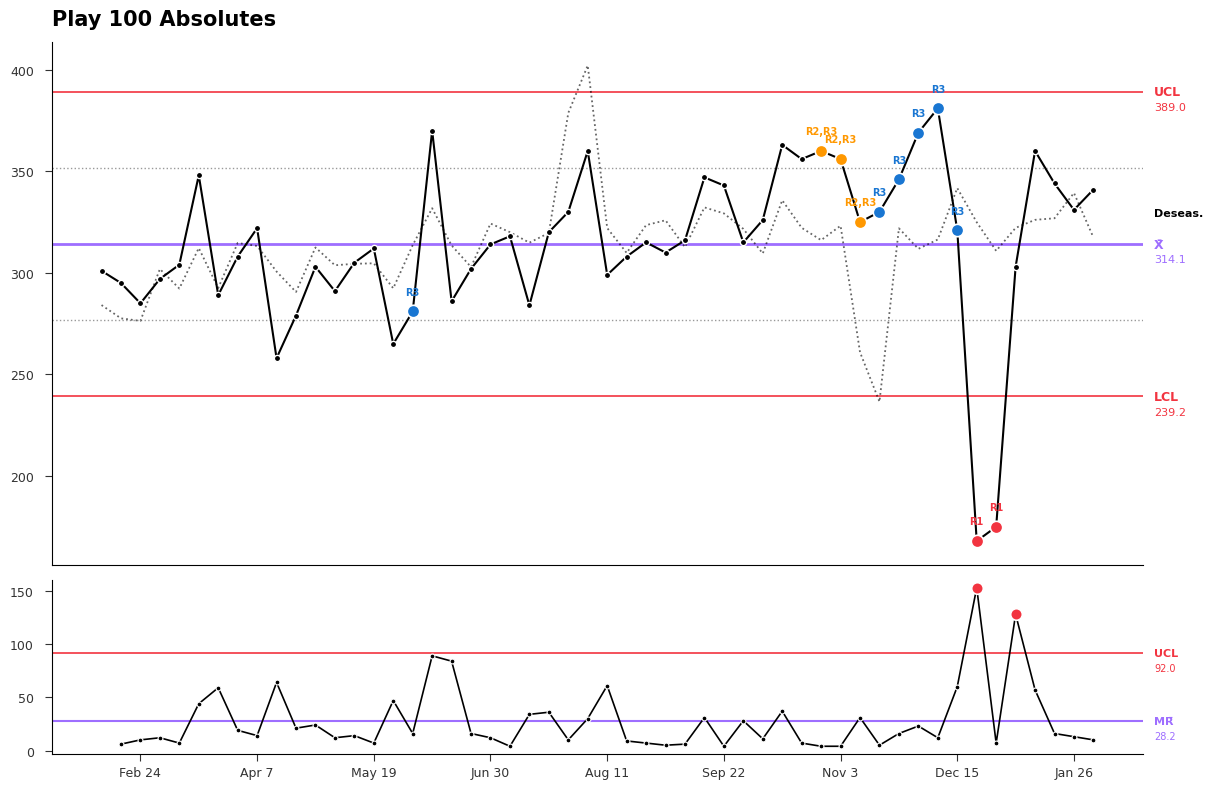

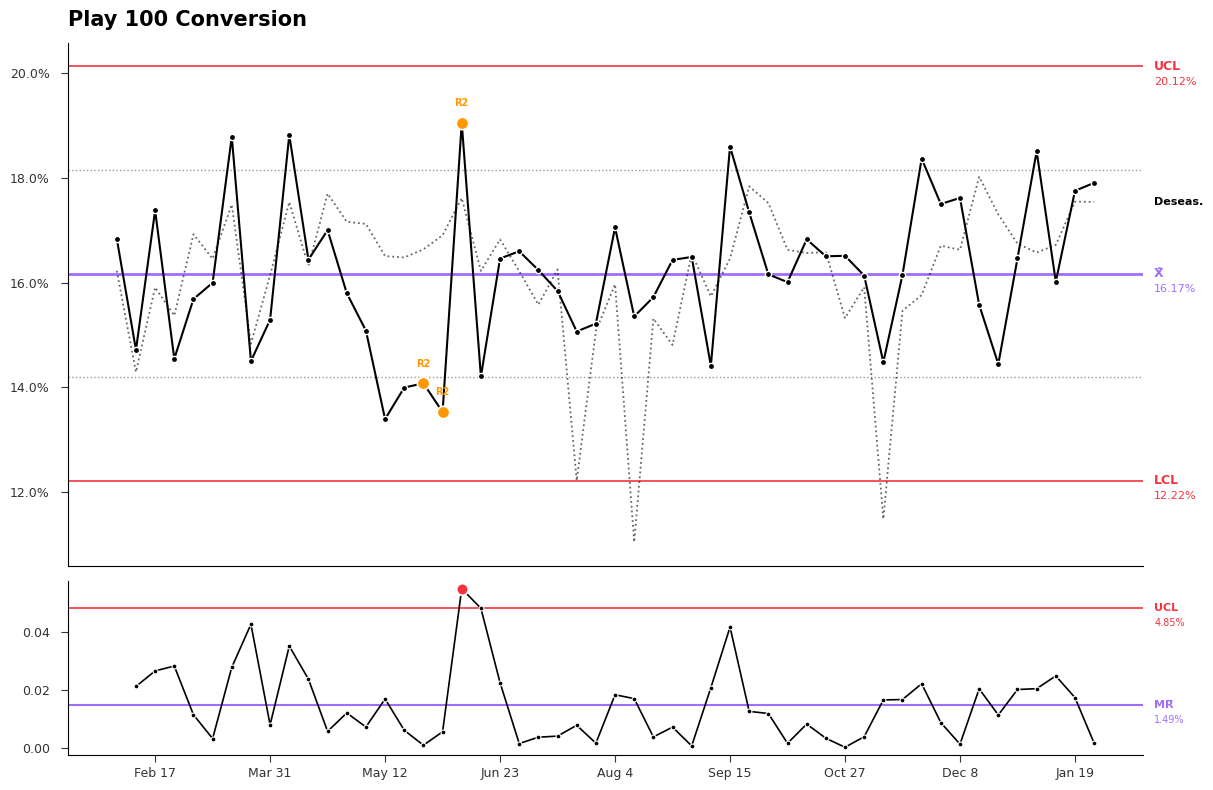

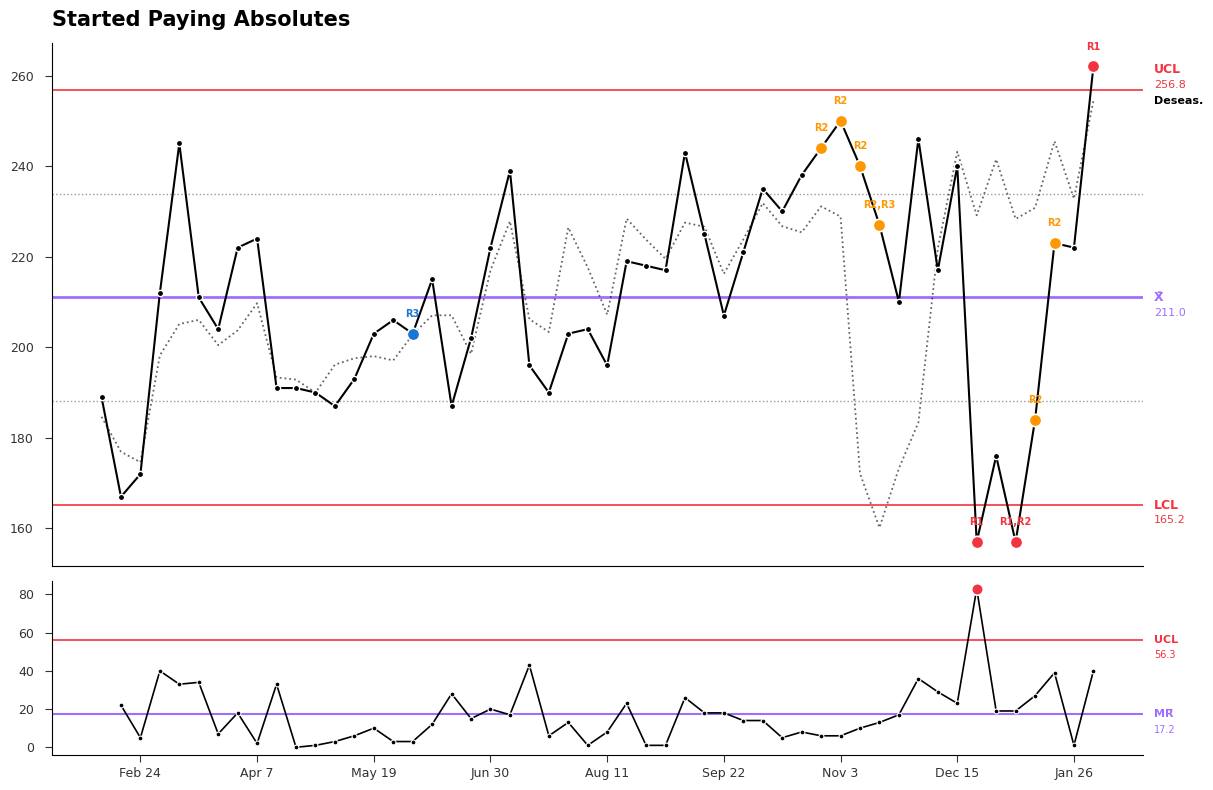

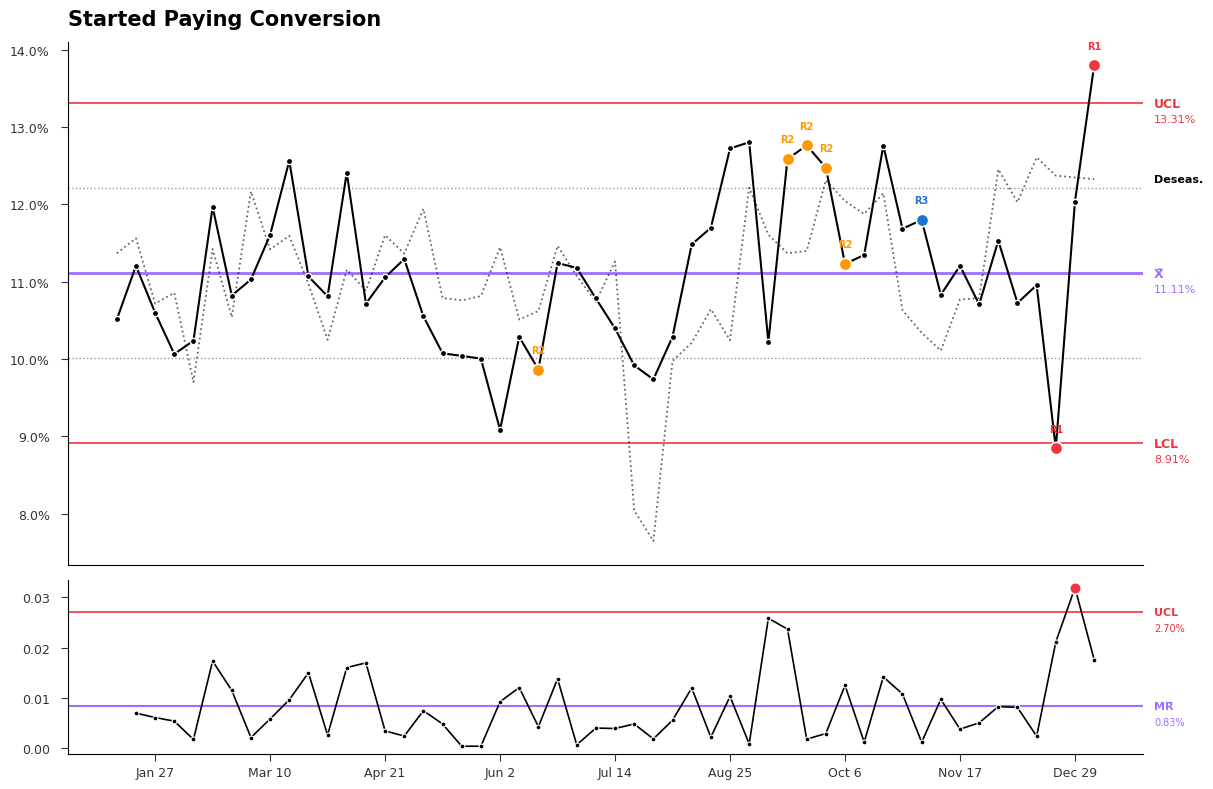

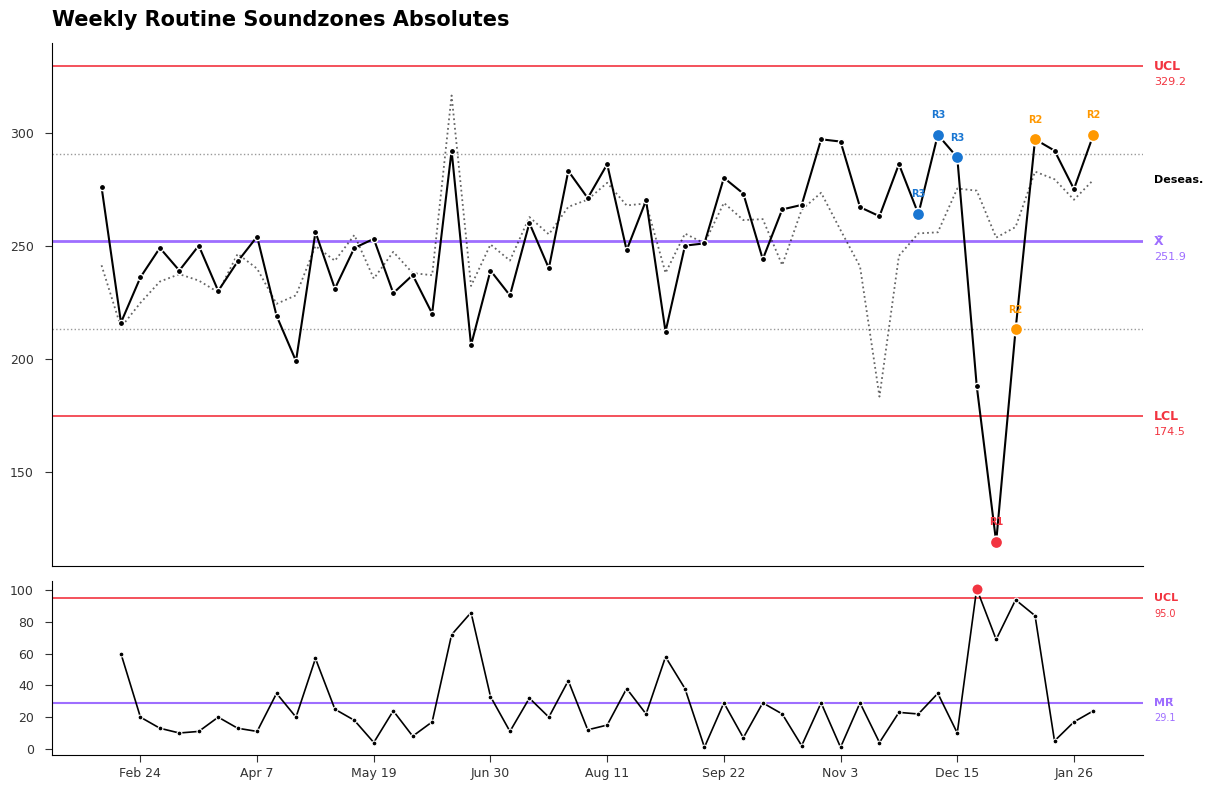

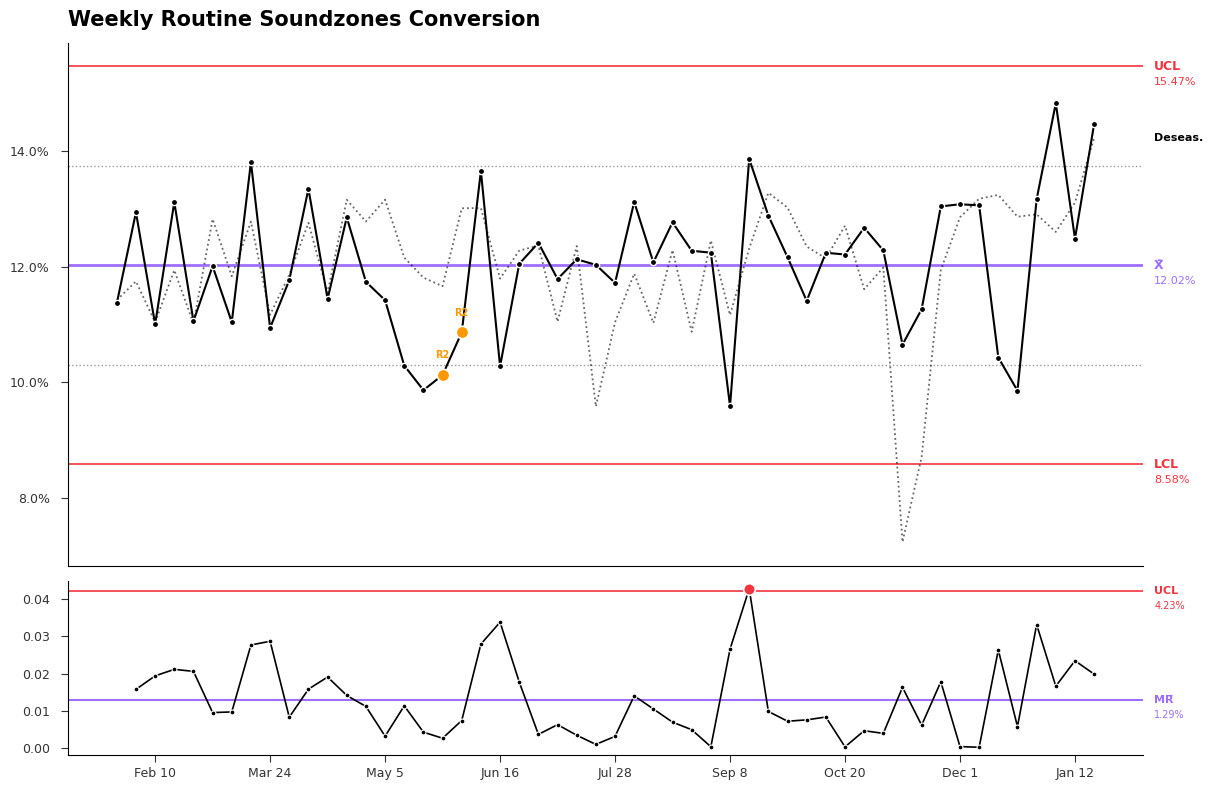


📋 Anomalies in last week (3 total):


,metric,period,value,moving_range,violation_labels_x,mr_anomaly,rule_1,rule_2,rule_3
0,Started Paying Absolutes,2026-02-02,262.0,40.0,R1,False,True,False,False
1,Started Paying Conversion,2026-01-05,0.137975,0.017605,R1,False,True,False,False
2,Weekly Routine Soundzones Absolutes,2026-02-02,299.0,24.0,R2,False,False,True,False



🔍 Drill-down for Started Paying Absolutes (contribution-weighted):
   ↑ marketing_parent_channel: non_paid — +26% vs SPC avg, contributes +66% of total move on Feb 02 [seasonal effect: +8]
   ↑ country_region: Europe — +40% vs SPC avg, contributes +58% of total move on Feb 02 [seasonal effect: +8]
      ↑ marketing_parent_channel: non_paid — +39% vs avg, +63% of segment move
      ↑ marketing_parent_channel: paid — +40% vs avg, +37% of segment move
   ↑ marketing_parent_channel: paid — +22% vs SPC avg, contributes +34% of total move on Feb 02 [seasonal effect: +8]
   ↑ country_region: US — +10% vs SPC avg, contributes +20% of total move on Feb 02 [seasonal effect: +8]
      ↑ marketing_parent_channel: non_paid — +11% vs avg, +65% of segment move

🔍 Drill-down for Started Paying Conversion (contribution-weighted):
   ↑ country_region: US — +36% vs SPC avg, contributes +185% of total move on Jan 05 [seasonal effect: +0]
      ↑ marketing_parent_channel: non_paid — +29% vs avg, +0% of se

In [8]:
# Run the complete analysis pipeline
output = run_spc_analysis(df, config)
results = output['results']
figures = output['figures']
commentary = output['commentary']
detected_dims = output['dimensions']

print(f"✅ Analysis complete for {len(results)} metrics ({config.report_period_label}):")
print(f"   Drill-down dimensions: {detected_dims}")
for name, data in results.items():
    status = commentary._assess_status(data)
    emoji = {'alert': '🚨', 'warning': '⚠️', 'stable': '✅'}[status]
    n_drilldown = len(data.get('drilldown', []))
    drill_info = f" | {n_drilldown} drill-down movers" if n_drilldown else ""
    print(f"   {emoji} {data['friendly_name']}{drill_info}")

# Display charts
for fig in figures.values():
    plt.show()

# ── Report-window anomalies table ────────────────────────────────────────────
all_anomalies = []
for metric_name, data in results.items():
    df_report = data['report_data']
    anomalies = df_report[df_report['is_anomaly_x'] | df_report['mr_anomaly']].copy()
    anomalies['metric'] = data['friendly_name']
    all_anomalies.append(anomalies)

if all_anomalies:
    anomalies_df = pd.concat(all_anomalies, ignore_index=True)
    if not anomalies_df.empty:
        display_cols = ['metric', config.date_column, config.value_column, 'moving_range',
                        'violation_labels_x', 'mr_anomaly']
        rule_cols = [f'rule_{i}' for i in config.rules_active if f'rule_{i}' in anomalies_df.columns]
        display_cols.extend(rule_cols)
        print(f"\n📋 Anomalies in {config.report_period_label} ({len(anomalies_df)} total):")
        display(anomalies_df[display_cols])
    else:
        print(f"\n✅ No anomalies in the {config.report_period_label}!")

# ── Drill-down summary ───────────────────────────────────────────────────────
for metric_name, data in results.items():
    if data.get('drilldown'):
        print(f"\n🔍 Drill-down for {data['friendly_name']} (contribution-weighted):")
        for d in data['drilldown'][:5]:
            arrow = '↑' if d['direction'] == 'up' else '↓'
            deseas_note = ""
            if 'agg_deseasonalized' in d:
                deseas_note = f" [seasonal effect: {d['agg_seasonal_effect']:+,.0f}]"
            print(f"   {arrow} {d['dimension']}: {d['dimension_value']} — "
                  f"{d['deviation_pct']:+.0f}% vs SPC avg, "
                  f"contributes {d['contribution_pct']:+.0f}% of total move"
                  f" on {d['date'].strftime('%b %d')}{deseas_note}")
            # Level-2 sub-drilldown
            for sub in d.get('sub_drilldown', [])[:3]:
                sub_arrow = '↑' if sub['direction'] == 'up' else '↓'
                print(f"      {sub_arrow} {sub['dimension']}: {sub['dimension_value']} — "
                      f"{sub['deviation_pct']:+.0f}% vs avg, "
                      f"{sub['contribution_pct']:+.0f}% of segment move")

# ── Template-based report (no LLM) ───────────────────────────────────────────
summaries = commentary.generate_all_summaries()
slack_message = commentary.format_slack_message(summaries)
print("\n" + slack_message)

## 4. LLM Commentary (Gemini)

In [9]:
# ── Load secrets ──────────────────────────────────────────────────────────────
load_dotenv(override=True)

GOOGLE_CLOUD_PROJECT = os.environ.get('GOOGLE_CLOUD_PROJECT', bq_project)
GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY')
SLACK_BOT_TOKEN = os.environ.get('SLACK_BOT_TOKEN')
SLACK_CHANNEL = os.environ.get('SLACK_CHANNEL', '#spc-reports')

SLACK_WEBHOOK_URL = os.environ.get('SLACK_WEBHOOK_URL')

print(f"Gemini API Key: {'✅' if GEMINI_API_KEY else '❌'}")
print(f"Slack Bot Token: {'✅' if SLACK_BOT_TOKEN else '❌'}")
print(f"Slack Channel: {SLACK_CHANNEL}")

# ── Build prompt ──────────────────────────────────────────────────────────────

def build_slack_bullet_prompt(commentary) -> str:
    """Build prompt that generates conversational, narrative-style summary."""
    cfg = commentary.config
    context = commentary.prepare_llm_context()
    rules_ref = "\n".join([
        f"- {SPC_DETECTION_RULES[f'rule_{i}']['short']}: {SPC_DETECTION_RULES[f'rule_{i}']['description']}"
        for i in cfg.rules_active
    ])
    now = datetime.now()
    week_number = now.isocalendar()[1]
    day_name = now.strftime('%A')

    # Grain-aware title & greeting
    if cfg.grain == 'daily':
        title = f"{cfg.grain_adjective} SPC metrics — {now.strftime('%b %d')}"
        greeting = f"Happy {day_name} team!"
        period_desc = "today's data point"
    elif cfg.grain == 'weekly':
        title = f"Week {week_number} SPC metrics"
        greeting = f"Happy {day_name} team!"
        period_desc = "this week's data point"
    else:  # monthly
        title = f"{now.strftime('%B %Y')} SPC metrics"
        greeting = f"Happy {now.strftime('%B')} team!"
        period_desc = "this month's data point"

    # Summarise drill-down data
    drilldown_section = ""
    summaries = commentary.generate_all_summaries()
    has_drilldown = any(s.get('drilldown') for s in summaries)
    if has_drilldown:
        lines = []
        for s in summaries:
            if s.get('drilldown'):
                lines.append(f"\n  {s['friendly_name']}:")
                for d in s['drilldown'][:5]:
                    base = (f"    - {d['dimension']}: {d['dimension_value']} — "
                            f"{d['deviation_pct']:+.0f}% vs its SPC-window avg, "
                            f"contributes {d['contribution_pct']:+.0f}% of total aggregate move "
                            f"({d['direction']})")
                    if 'agg_seasonal_effect' in d:
                        base += f" | seasonal effect on aggregate: {d['agg_seasonal_effect']:+,.0f}"
                    # Level-2 sub-drill
                    for sub in d.get('sub_drilldown', [])[:3]:
                        base += (f"\n      └ {sub['dimension']}: {sub['dimension_value']} — "
                                 f"{sub['deviation_pct']:+.0f}% vs avg, "
                                 f"{sub['contribution_pct']:+.0f}% of this segment's move "
                                 f"({sub['direction']})")
                    lines.append(base)
        drilldown_section = f"""

DRILL-DOWN ANALYSIS (what drove the anomalies):
Each dimension value shows two key percentages:
  • deviation_pct: how far it deviated from its own SPC-window average
  • contribution_pct: what share of the total aggregate deviation this segment explains
    (positive = same direction as aggregate move, negative = offsetting)
Level-2 sub-drills show the same breakdown within a top-mover segment, decomposed by other dimensions.
Averages are based on the SPC window ({cfg.spc_window} most recent data points), not all-time history.
{"".join(lines)}
"""

    return f"""You are a data analyst writing a {cfg.grain} metrics update for your team in Slack. Your audience includes both technical and non-technical colleagues (execs, managers, analysts).

CONTEXT:
- These are Statistical Process Control (SPC) metrics tracking growth funnels
- Metrics come in two types (check the metric_type field):
  • "absolute" — raw counts (e.g. signups, page views). Values are integers.
  • "conversion" — ratios (e.g. storefront-to-signup rate). Values are decimals between 0 and 1; format them as percentages (e.g. 0.12 → 12%).
- The data grain is {cfg.grain} — each data point represents one {cfg.grain_label}
- Control limits are calculated on the last {cfg.spc_window} data points
- This report covers {period_desc} only (the {cfg.report_period_label})
- Signals indicate when a metric is behaving unusually (outside normal variation)
- Rules reference:
{rules_ref}
- MR_violation = unusual volatility between consecutive data points
- Metrics include STL seasonal decomposition for context (calculated on full history).
  When is_deseasonalized=true: seasonal_amplitude shows the typical periodic swing,
  current_seasonal_effect shows how much seasonality inflates/deflates the latest value.
  Use this to distinguish genuine anomalies from expected seasonal patterns.
- Today is {day_name}, and this is Week {week_number}

METRICS DATA ({cfg.report_period_label}):
{context}
{drilldown_section}
TASK:
Write the COMPLETE Slack message for a {cfg.grain} metrics update. This will be posted directly — do not add any meta-commentary or markdown code fences.

Use EXACTLY this structure:

*{title}*

{greeting} [emoji]
[1 sentence about the overall state of things]

[Optional: 1-2 sentence context paragraph if there are notable patterns worth calling out]

*TL;DR*
[emoji] *[Metric Name]*: [One sentence summary]
[repeat for each metric — use ✅ stable, ⚠️ warning, 🚨 critical]

*Breakdown of metrics*
• *[Metric Name]*
   ◦ [Key observation about the data]
   ◦ [Assessment of control limits / stability]
   ◦ [If there are drill-down movers: mention which dimension(s) drove the anomaly, e.g. "Driven by a drop in [country/region]"]
   ◦ [Business implication if any]
[repeat for each metric, using bullet + sub-bullet format]

If you have any questions, please let me know!

FORMATTING RULES:
- This is Slack mrkdwn (NOT standard Markdown!)
- For bold: use single asterisks like *this is bold* (NEVER use **double asterisks**)
- For italic: use underscores like _this is italic_ (NEVER use *single asterisks*)
- Examples of correct formatting:
  * Correct: *{title}* → renders as bold
  * Correct: *TL;DR* → renders as bold section header
  * WRONG: **{title}** → will show asterisks literally
- Use • for top-level bullets and ◦ for sub-bullets
- Do NOT include any detection rules reference section
- Do NOT include any links section at the end (links are appended automatically)
- Do NOT wrap output in code fences

STYLE RULES:
- Write like you're talking to colleagues, not reading from a textbook
- Use contractions where natural (it's, we're, there's)
- Be specific with numbers and dates when referencing anomalies
- Explain SPC rules in plain language (e.g., "showing a sustained upward trend" instead of just "Rule 5")
- When metrics are stable, say so clearly: "within control limits" or "no concerning signals"
- When there are signals, explain what they mean in business terms
- When drill-down data is available, weave it naturally into the narrative (e.g., "This was driven by a spike in [region]" rather than listing raw numbers)
- Sound thoughtful and analytical, not robotic
- Keep sub-bullets digestible (1-2 sentences each)

Write ONLY the Slack message, nothing else."""


custom_prompt = build_slack_bullet_prompt(commentary)
print(f"✅ Prompt built ({len(custom_prompt):,} chars)")

# ── Call Gemini ───────────────────────────────────────────────────────────────

def generate_llm_summary_gemini(prompt: str, api_key: str = None, project: str = None) -> str:
    """Call Gemini API to generate the summary."""
    if api_key:
        from google import genai
        client = genai.Client(api_key=api_key)
        response = client.models.generate_content(model='gemini-3-pro-preview', contents=prompt)
        return response.text
    elif project:
        import vertexai
        from vertexai.generative_models import GenerativeModel
        vertexai.init(project=project, location="us-central1")
        model = GenerativeModel("gemini-3-pro-preview")
        response = model.generate_content(prompt)
        return response.text
    else:
        raise ValueError("Provide either api_key or project")


print("🤖 Calling Gemini to generate summary...")
try:
    if GEMINI_API_KEY:
        executive_summary = generate_llm_summary_gemini(custom_prompt, api_key=GEMINI_API_KEY)
    else:
        executive_summary = generate_llm_summary_gemini(custom_prompt, project=GOOGLE_CLOUD_PROJECT)
    print("✅ Summary generated!\n")
    print(executive_summary)
except Exception as e:
    print(f"❌ Error: {e}")
    print("\nTo fix this, either:")
    print("1. Set GEMINI_API_KEY from https://aistudio.google.com/apikey")
    print("2. Or ensure Vertex AI API is enabled in your GCP project")
    executive_summary = None

Gemini API Key: ✅
Slack Bot Token: ✅
Slack Channel: #soundhack2026-reportbot
✅ Prompt built (21,613 chars)
🤖 Calling Gemini to generate summary...


2026-02-16 14:56:24,971 - INFO - AFC is enabled with max remote calls: 10.
2026-02-16 14:56:58,817 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-3-pro-preview:generateContent "HTTP/1.1 200 OK"


✅ Summary generated!

*Week 8 SPC metrics*

Happy Monday team! 👋
We're seeing a very strong week for the "Started Paying" funnel with significant positive anomalies in both volume and conversion rates, largely driven by European and North American markets.

*TL;DR*
🚨 *Started Paying Absolutes*: Significant spike above control limits, primarily driven by non-paid traffic in Europe.
🚨 *Started Paying Conversion*: Rate jumped to 13.8%, exceeding the upper limit due to strong performance in the US and Canada.
⚠️ *Weekly Routine Soundzones Absolutes*: Monitoring a "high cluster" warning driven by Paid channels.
✅ *Play 100 Absolutes*: Stable and within expected range.
✅ *Play 100 Conversion*: Stable; no concerning signals.
✅ *Weekly Routine Soundzones Conversion*: Stable.

*Breakdown of metrics*
• *Started Paying Absolutes*
   ◦ We hit 262 this week, which is a critical breach of our upper process limit (historical mean is 211).
   ◦ While we expected a slight seasonal lift (+8), the actual

## 5. Publish

In [10]:
# ── Slack helpers ─────────────────────────────────────────────────────────────

def upload_chart(headers: dict, fig, metric_name: str, config) -> str | None:
    """Upload a chart to Slack. Returns file_id."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight', facecolor=config.colors['background'])
    buf.seek(0)
    content = buf.read()
    safe_name = "".join([c if c.isalnum() else "_" for c in metric_name])
    resp = requests.post("https://slack.com/api/files.getUploadURLExternal", headers=headers,
                        data={"filename": f"SPC_{safe_name}.png", "length": len(content)})
    if not resp.json().get("ok"):
        return None
    requests.post(resp.json()["upload_url"], files={"file": (f"SPC_{safe_name}.png", content, "image/png")})
    buf.close()
    return resp.json()["file_id"]


def resolve_channel_id(headers: dict, channel: str) -> str | None:
    """Get channel ID by posting and deleting a test message."""
    resp = requests.post("https://slack.com/api/chat.postMessage", headers=headers,
                        json={"channel": channel, "text": "..."})
    if resp.json().get("ok"):
        channel_id = resp.json()["channel"]
        requests.post("https://slack.com/api/chat.delete", headers=headers,
                     json={"channel": channel_id, "ts": resp.json()["ts"]})
        return channel_id
    return None


def post_to_slack(bot_token: str, channel: str, message: str, figures: dict, config) -> bool:
    """Post message with charts attached to a single message."""
    headers = {"Authorization": f"Bearer {bot_token}"}
    file_ids = [{"id": fid, "title": f"XmR: {config.get_metric_label(n)}"}
                for n, fig in figures.items() if fig and (fid := upload_chart(headers, fig, n, config))]
    if not file_ids:
        resp = requests.post("https://slack.com/api/chat.postMessage", headers=headers,
                            json={"channel": channel, "text": message})
        print("✅ Posted" if resp.json().get("ok") else f"❌ {resp.json().get('error')}")
        return resp.json().get("ok", False)
    channel_id = channel if channel.startswith("C") else resolve_channel_id(headers, channel)
    if not channel_id:
        print(f"❌ Cannot resolve channel: {channel}")
        return False
    resp = requests.post("https://slack.com/api/files.completeUploadExternal", headers=headers,
                        json={"files": file_ids, "channel_id": channel_id, "initial_comment": message})
    print(f"✅ Posted with {len(file_ids)} charts" if resp.json().get("ok") else f"❌ {resp.json().get('error')}")
    return resp.json().get("ok", False)


# ── Compose & send ────────────────────────────────────────────────────────────
# Use the LLM-generated summary as the complete message; fall back to template if needed
full_message = commentary.format_slack_message(summaries, executive_summary=executive_summary if executive_summary else None)
print(full_message)

# ⚠️ Confirmation required before posting
confirm = input("\n⚠️  Post to Slack? (yes/y to confirm): ").strip().lower()
if confirm in ['yes', 'y']:
    if SLACK_BOT_TOKEN:
        post_to_slack(SLACK_BOT_TOKEN, SLACK_CHANNEL, full_message, figures, config)
    else:
        print("❌ Set SLACK_BOT_TOKEN in .env")
else:
    print("❌ Cancelled")

*Week 8 SPC metrics*

Happy Monday team! 👋
We're seeing a very strong week for the "Started Paying" funnel with significant positive anomalies in both volume and conversion rates, largely driven by European and North American markets.

*TL;DR*
🚨 *Started Paying Absolutes*: Significant spike above control limits, primarily driven by non-paid traffic in Europe.
🚨 *Started Paying Conversion*: Rate jumped to 13.8%, exceeding the upper limit due to strong performance in the US and Canada.
⚠️ *Weekly Routine Soundzones Absolutes*: Monitoring a "high cluster" warning driven by Paid channels.
✅ *Play 100 Absolutes*: Stable and within expected range.
✅ *Play 100 Conversion*: Stable; no concerning signals.
✅ *Weekly Routine Soundzones Conversion*: Stable.

*Breakdown of metrics*
• *Started Paying Absolutes*
   ◦ We hit 262 this week, which is a critical breach of our upper process limit (historical mean is 211).
   ◦ While we expected a slight seasonal lift (+8), the actual jump goes far beyond 